In [58]:
import torch
import torch.nn as neural
import torch.nn.functional as function
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms


import kagglehub
path = kagglehub.dataset_download("mehradaria/leukemia")
path2 = kagglehub.dataset_download("mehradaria/leukemia")

path = path + "/Original"
path2 = path2 + "/Segmented"

print(path)
print(path2)

#datasets
dataset = datasets.ImageFolder(root=path, transform=transforms.ToTensor())
dataset_segmented = datasets.ImageFolder(root=path2, transform=transforms.ToTensor())

path2 = kagglehub.dataset_download("mehradaria/leukemia")


train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=64)


images, labels = next(iter(train_loader))
print(images.shape)
print(labels)

classes = ["Bening", "Early", "Pre", "Pro"]


for label in dataset.classes:
    print(label)



C:\Users\valen\.cache\kagglehub\datasets\mehradaria\leukemia\versions\1/Original
C:\Users\valen\.cache\kagglehub\datasets\mehradaria\leukemia\versions\1/Segmented
torch.Size([64, 3, 224, 224])
tensor([1, 2, 2, 0, 2, 3, 3, 1, 1, 0, 1, 2, 2, 1, 2, 3, 2, 2, 1, 3, 1, 0, 2, 1,
        1, 3, 3, 0, 1, 2, 1, 2, 2, 3, 2, 3, 0, 2, 3, 0, 1, 2, 1, 0, 2, 3, 1, 1,
        1, 1, 1, 0, 2, 1, 2, 1, 2, 0, 3, 0, 3, 3, 1, 3])
Benign
Early
Pre
Pro


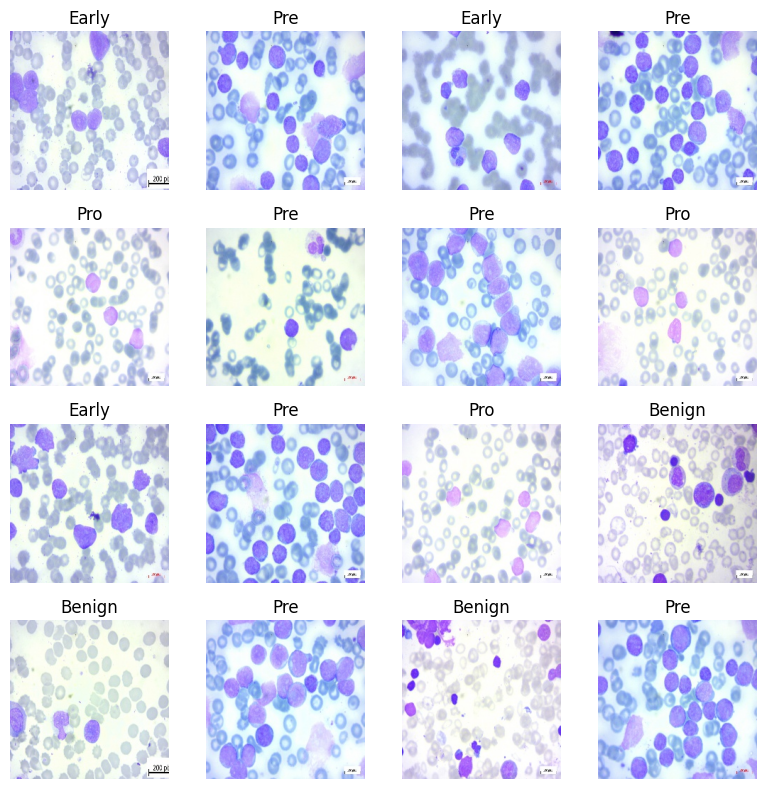

In [36]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    img = images[i].permute(1, 2, 0,).numpy()
    label = dataset.classes[labels[i]]
    ax.imshow(img)
    ax.set_title(label)
    ax.axis('off')

plt.tight_layout()
plt.show()

In [51]:
#funciones útiles
def get_optimizer(optimizer, model, lr): #selector de optimizador
    if optimizer == 1:
         return torch.optim.SGD(model.parameters(), lr=lr)
    if optimizer == 2:
        return torch.optim.Adam(model.parameters(), lr=lr)
    if optimizer == 3:
        return torch.optim.RMSprop(model.parameters(), lr=lr) 
    if optimizer == 4:
        return torch.optim.Adadelta(model.parameters(), lr=lr)
    
def calculate_w(w, f, p, s): #calculo de tamaño de salida de una capa convolucional
    return int((w - f + 2 * p) / s + 1)

In [56]:
class CNN(neural.Module):
    def __init__(self,learning_rate, loss_function, optimizer, kernel_sizes): 
        super(CNN, self).__init__()
        #hiperparametetros
        self.learning_rate = learning_rate
        self.loss_function = loss_function
        #self.config = config
        self.kernel_sizes = kernel_sizes #kernel_sizes[0] = 5*5, #kernel_sizes[1] = 3*
        
        #output size = (W - F + 2P)/S + 1 , W = input size, F = filter size, P = padding, S = stride
        #conv1:  W = 224, F = 5, P = 0, S = 1  -> 220
        #pool: W=220, F = 2, P = 0, S = 2  -> 110
        #conv2: W = 110, F = 3, P = 0, S = 1  -> 108
        #pool: W=108, F = 2, P = 0, S = 2  -> 54
        
        #arquitectura de capas
        self.conv1 = neural.Conv2d(3, 6, kernel_sizes[0]) 
        self.pool = neural.MaxPool2d(2, 2)
        self.conv2 = neural.Conv2d(6, 16, kernel_sizes[1]) 
        self.linear = neural.Linear(16 * 54 * 54, 128)
        self.linear2 = neural.Linear(128, 64)
        self.output = neural.Linear(64, 4)
        
        self.optimizer = get_optimizer(optimizer, self, learning_rate)
        
        

        
    def forward(self,x):
        x = function.relu(self.conv1(x))
        x = self.pool(x)
        x = function.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 16 * 54 * 54)
        x = function.relu(self.linear(x))
        x = function.relu(self.linear2(x))
        x = self.output(x)
        return x


In [ ]:
#Configuración externa y manual de hiperparámetros
disp = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", disp)


learning_rate = 0.001
batch_size = 64
num_epochs = 100
kernel_sizes = [5,3]

loss_function = torch.nn.CrossEntropyLoss()
optimizer = 2

False
Using device: cpu


In [54]:
def train_model(model, train_loader, val_loader, num_epochs, device):
    best_acc = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            model.optimizer.zero_grad()
            outputs = model(images)
            loss = model.loss_function(outputs, labels)
            loss.backward()
            model.optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(train_loader)

        # --- VALIDACIÓN ---
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {avg_loss:.4f} | Val Acc: {acc:.2f}%")

        # Guardar el mejor modelo
        if acc > best_acc:
            best_acc = acc
            torch.save(model.state_dict(), "best_model.pth")

In [67]:
#Crear y entrenar un modelo

model = CNN(learning_rate, loss_function, optimizer, kernel_sizes).to(disp)
train_model(model, train_loader, val_loader, num_epochs, disp)

Epoch [1/100] | Loss: 0.9951 | Val Acc: 72.31%
Epoch [2/100] | Loss: 0.6061 | Val Acc: 76.00%
Epoch [3/100] | Loss: 0.4730 | Val Acc: 72.31%
Epoch [4/100] | Loss: 0.4042 | Val Acc: 81.54%
Epoch [5/100] | Loss: 0.3434 | Val Acc: 80.00%
Epoch [6/100] | Loss: 0.2746 | Val Acc: 71.08%
Epoch [7/100] | Loss: 0.3055 | Val Acc: 84.31%
Epoch [8/100] | Loss: 0.2348 | Val Acc: 83.69%
Epoch [9/100] | Loss: 0.3380 | Val Acc: 82.77%
Epoch [10/100] | Loss: 0.1781 | Val Acc: 84.31%
Epoch [11/100] | Loss: 0.1605 | Val Acc: 84.62%
Epoch [12/100] | Loss: 0.0862 | Val Acc: 84.62%
Epoch [13/100] | Loss: 0.0963 | Val Acc: 84.31%
Epoch [14/100] | Loss: 0.0695 | Val Acc: 85.54%
Epoch [15/100] | Loss: 0.0491 | Val Acc: 84.00%
Epoch [16/100] | Loss: 0.0427 | Val Acc: 82.46%
Epoch [17/100] | Loss: 0.0414 | Val Acc: 85.23%
Epoch [18/100] | Loss: 0.0163 | Val Acc: 87.08%
Epoch [19/100] | Loss: 0.0084 | Val Acc: 86.77%
Epoch [20/100] | Loss: 0.0064 | Val Acc: 86.46%
Epoch [21/100] | Loss: 0.0047 | Val Acc: 87.38%
E

In [68]:
def test_model(model, test_loader, device):
    # Cargar el modelo entrenado si es que guardaste "best_model.pth"
    model.load_state_dict(torch.load("best_model.pth", map_location=device))
    model.to(device)
    model.eval()  # importantísimo: desactiva dropout, batchnorm, etc.

    correct = 0
    total = 0
    running_loss = 0.0

    with torch.no_grad():  # no necesitamos gradientes en test
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = model.loss_function(outputs, labels)
            running_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    avg_loss = running_loss / len(test_loader)
    accuracy = 100 * correct / total

    print(f"Test Loss: {avg_loss:.4f} | Test Accuracy: {accuracy:.2f}%")
    return avg_loss, accuracy

In [69]:
test_loss, test_acc = test_model(model, test_loader, disp)

from sklearn.metrics import confusion_matrix
import numpy as np

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(disp), labels.to(disp)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
print(cm)


Test Loss: 0.4663 | Test Accuracy: 83.79%
[[25 15  1  4]
 [16 80  6  1]
 [ 3  4 82  0]
 [ 3  0  0 87]]


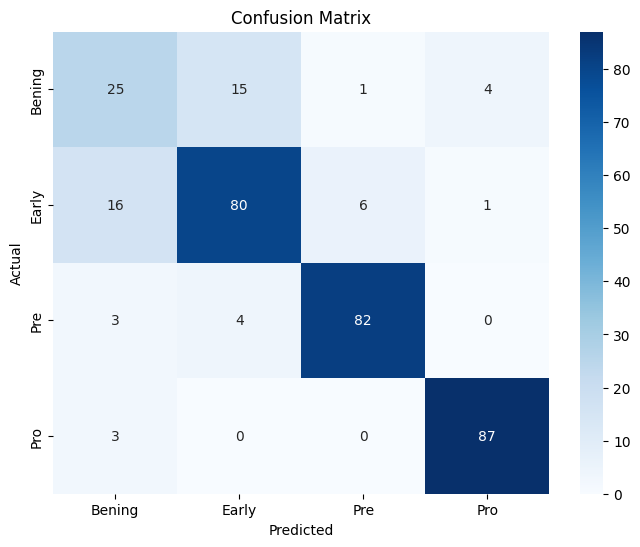

In [70]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_confusion_matrix(model, test_loader, device, class_names=None):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Calcular matriz de confusión
    cm = confusion_matrix(all_labels, all_preds)
    
    # Graficar con seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


plot_confusion_matrix(model, test_loader, disp, class_names=classes)

In [88]:
class CNN2(neural.Module):
    def __init__(self, learning_rate, loss_function, optimizer, config, input_size=224, num_classes=4):
        super(CNN2, self).__init__()

        self.learning_rate = learning_rate
        self.loss_function = loss_function
        self.config = config  # ahora se almacena la configuración completa
        self.num_classes = num_classes

        # Construcción dinámica de capas convolucionales
        self.conv_layers = neural.ModuleList()
        in_channels = 3
        W = input_size

        for out_channels, k, s, p in config:
            conv = neural.Conv2d(in_channels, out_channels, kernel_size=k, stride=s, padding=p)
            self.conv_layers.append(conv)
            # Calcular tamaño de salida después de la convolución
            W = calculate_w(W, k, p, s)
            # Pooling 2x2 fijo
            W = calculate_w(W, 2, 0, 2)
            in_channels = out_channels

        # Capas fully-connected
        fc_input_size = in_channels * W * W
        self.linear1 = neural.Linear(fc_input_size, 64)
        self.linear2 = neural.Linear(64, 16)
        self.output = neural.Linear(16, num_classes)

        # Optimizer dentro del modelo
        self.optimizer = get_optimizer(optimizer, self, learning_rate)

    def forward(self, x):
        for conv in self.conv_layers:
            x = function.relu(conv(x))
            x = function.max_pool2d(x, 2)  # pooling fijo 2x2
        x = x.view(x.size(0), -1)
        x = function.relu(self.linear1(x))
        x = function.relu(self.linear2(x))
        x = self.output(x)
        return x

In [89]:
#Definición de hiperparámetros
loss_function2 = torch.nn.CrossEntropyLoss()
optimizer2 = 2
config = [
    [6, 5, 1, 0],
    [12, 3, 1, 0],
    [32, 3, 1, 1]
]

model2 = CNN2(0.001, loss_function2, optimizer2, config, input_size=224, num_classes=4)
print(model2)

train_model(model2, train_loader, val_loader, num_epochs, disp)

test_loss2, test_acc2 = test_model(model2, test_loader, disp)
plot_confusion_matrix(model2, test_loader, disp, class_names=classes)

CNN2(
  (loss_function): CrossEntropyLoss()
  (conv_layers): ModuleList(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1))
    (2): Conv2d(12, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  )
  (linear1): Linear(in_features=23328, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=4, bias=True)
)
Epoch [1/100] | Loss: 1.1822 | Val Acc: 53.23%
Epoch [2/100] | Loss: 0.7439 | Val Acc: 73.23%
Epoch [3/100] | Loss: 0.6019 | Val Acc: 79.08%
Epoch [4/100] | Loss: 0.4730 | Val Acc: 82.15%
Epoch [5/100] | Loss: 0.4016 | Val Acc: 79.69%
Epoch [6/100] | Loss: 0.3332 | Val Acc: 80.31%
Epoch [7/100] | Loss: 0.3182 | Val Acc: 80.00%
Epoch [8/100] | Loss: 0.2727 | Val Acc: 78.77%
Epoch [9/100] | Loss: 0.2364 | Val Acc: 84.00%
Epoch [10/100] | Loss: 0.1874 | Val Acc: 80.31%
Epoch [11/100] | Loss: 0.2252 | Val Acc: 77.54%
Epoch [12/100] | Lo

KeyboardInterrupt: 